<a href="https://colab.research.google.com/github/Manisha2297/RestroRecommender/blob/main/Baseline%20model%20using%20Business_JSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib


import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import seaborn as sns
from scipy import stats 
from datetime import datetime

from sklearn.model_selection import train_test_split


In [3]:
business_df = pd.read_pickle('/content/drive/MyDrive/YelpDataset/PickleFiles/restuarant_df')
business_df.shape

(56901, 14)

In [4]:
business_df = business_df.astype({'latitude':'float','longitude':'float','review_count':'int64','stars':'float'})

In [5]:
business_df.dtypes

address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open          object
latitude        float64
longitude       float64
name             object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

In [6]:
from ast import literal_eval
business_df['attributes'] = business_df['attributes'].fillna("{'None':'None'}") #Removing None values
business_df['attributes_edited'] = business_df['attributes'].apply(lambda x: literal_eval(x)) #Transforming the stringified dictionary to dictionary

business_df['categories_edited'] = business_df['categories'].apply(lambda x: x.split(',')) #Transforming the stringified list to list

In [7]:
print(business_df['state'].value_counts().index) #NVM this cell. Not used anywhere
aa = []
for i in business_df['state'].value_counts().index:
  aa.append(business_df[business_df['state']==i]['city'].nunique())
print(aa)  

Index(['ON', 'AZ', 'NV', 'QC', 'OH', 'NC', 'PA', 'AB', 'WI', 'IL', 'SC'], dtype='object')
[86, 53, 25, 204, 164, 41, 169, 15, 29, 21, 13]


In [8]:
#Will explain cell 8-13 on call
attribute_keys = []
# business_df['attributes_edited'].apply(lambda x: keys.append(x.keys()))
for i in business_df['attributes_edited']:
  attribute_keys.append(list(i.keys()))

attribute_keys = [item for sublist in attribute_keys for item in sublist]
print(len(attribute_keys))

unique_keys = list(set(attribute_keys))
print('Number of unique attributes in dataset:',len(unique_keys))

747696
Number of unique attributes in dataset: 40


In [9]:
# for i in business_df['attributes_edited'][0]:
#   print(i+'_'+business_df['attributes_edited'][0][i])

In [10]:
attribute_combo = []
for i in business_df['attributes_edited']:
  # print(list(i.keys()))
  for j in list(i.keys()):
    attribute_combo.append(j+'_'+i[j])

In [11]:
Attributes_Without_Dicts = []
for i in list(set(attribute_combo)):
  if i.split('_')[1][0] == '{':
    continue
  else:
    Attributes_Without_Dicts.append(i)
Attributes_Without_Dicts[:10]

["Alcohol_u'beer_and_wine'",
 "BYOBCorkage_u'no'",
 'AcceptsInsurance_True',
 "AgesAllowed_u'19plus'",
 'AcceptsInsurance_False',
 'RestaurantsReservations_True',
 'BikeParking_True',
 "WiFi_u'free'",
 "Smoking_'outdoor'",
 'DriveThru_None']

In [12]:
def Attributes_Func(row):
  xx = []
  for i in row.keys():
      xx.append(i+'_'+row[i])
  
  final_list = []
  for i in xx:
    if i.split('_')[1][0] == '{':
      continue
    else:
      final_list.append(i) 
  return(final_list)

In [13]:
business_df['Attributes_List'] = business_df['attributes_edited'].apply(lambda x: Attributes_Func(x))

In [14]:
df_for_matrix = business_df[['business_id','Attributes_List','categories_edited']] #This is what our final DF for Count Vectorizer looks like
df_for_matrix.head()

,business_id,Attributes_List,categories_edited
0,pQeaRpvuhoEqudo3uymHIQ,"[RestaurantsAttire_u'casual', RestaurantsTakeO...","[Ethnic Food, Food Trucks, Specialty Food, ..."
1,M_guz7Dj7hX0evS672wIwA,"[BikeParking_True, Caters_True, WheelchairAcce...","[Desserts, Food, Ice Cream & Frozen Yogurt]"
2,mKTq1T_IAplDpHUcMzOXkw,[BusinessAcceptsCreditCards_True],"[Hotels & Travel, Transportation, Taxis, Be..."
3,eBEfgOPG7pvFhb2wcG9I7w,"[RestaurantsTableService_False, RestaurantsDel...","[Restaurants, Cheesesteaks, Poutineries]"
4,lu7vtrp_bE9PnxWfA8g4Pg,"[GoodForKids_True, RestaurantsTakeOut_True, Al...","[Japanese, Fast Food, Food Court, Restaurants]"


In [15]:
# Function to convert all strings to lower case and strip names of spaces
#Code from Data Camp. Cleaning the text by converting to lower case
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [16]:
features = ['business_id', 'Attributes_List', 'categories_edited']

for feature in features:
    df_for_matrix[feature] = df_for_matrix[feature].apply(clean_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
def create_soup(x):
    return(' '.join(x['Attributes_List']) + ' ' + ' '.join(x['categories_edited']) + ' ' + x['business_id'])

In [18]:
df_for_matrix['soup'] = df_for_matrix.apply(create_soup, axis=1) #Joining values so it looks like next cell

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_for_matrix[['soup']].head(2).values

array([["restaurantsattire_u'casual' restaurantstakeout_true businessacceptscreditcards_true noiselevel_u'quiet' goodforkids_false restaurantsreservations_false restaurantsgoodforgroups_false businessparking_none restaurantspricerange2_1 hastv_true alcohol_'none' bikeparking_false restaurantsdelivery_true byappointmentonly_false outdoorseating_false ethnicfood foodtrucks specialtyfood importedfood argentine food restaurants empanadas pqearpvuhoequdo3uymhiq"],
       ["bikeparking_true caters_true wheelchairaccessible_true restaurantspricerange2_1 wifi_u'no' businessacceptscreditcards_true restaurantstakeout_true desserts food icecream&frozenyogurt m_guz7dj7hx0evs672wiwa"]],
      dtype=object)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_for_matrix['soup']) #Creating Count Vectorier matrix

In [21]:
count_matrix.shape

(56901, 72150)

In [44]:
Stars = business_df[['review_count','stars']]

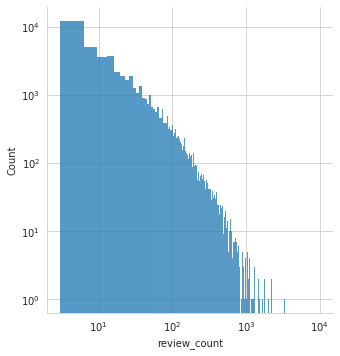

In [45]:
sns.set_style("whitegrid")
sns.displot(data=Stars, x='review_count')
plt.yscale("log")
plt.xscale("log")

In [56]:
C = Stars['stars'].mean() #This cell is Normalizing the Stars values based on the number of reviews they got. Will explain further on call. This is the same technique that is used in IMDB for their top 250 list
m = 50
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['review_count']
    R = x['stars']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

Stars['score'] = Stars.apply(weighted_rating, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [72]:
from scipy.sparse import hstack
count_matrix = hstack((count_matrix,np.array(Stars['score'])[:,None])) #I'm trying to add the Score column to the sparse matrix but not able to add it. Have to figure out why
count_matrix.shape

ValueError: ignored

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix) #Kernel crashes when trying to run this cell